#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../scripts')
import diffusion_utils

import networkx as nx

from copy import deepcopy

from tqdm import tqdm

In [147]:
import importlib
importlib.reload(diffusion_utils)

<module 'diffusion_utils' from '/Users/oseckin/Documents/GitHub/belief_network_extended/notebooks/../scripts/diffusion_utils.py'>

## Star Network Belief Systems

#### Create the social network

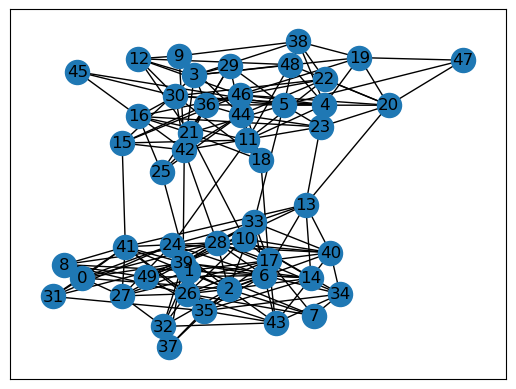

In [2]:
N = 50
M = 400
mu = .05

social_G, communities = diffusion_utils.community_social_network(N = 50, mu = .05, M = 200)

nx.draw_networkx(social_G)

#### Generate and embed the belief networks inside the social network

In [3]:
social_G = diffusion_utils.generate_embed_belief_networks_to_social_network(social_G, communities)

#### Run the simulation

In [32]:
def get_avg_measures(social_G):
    
    temp1 = {'intra-group':[], 'inter-group':[], 'aggregate':[]}
    temp2 = {'intra-group':[], 'inter-group':[], 'aggregate':[]}

    for e in social_G.edges():
        w1 = social_G.nodes[e[0]]['belief_network'].edges[e]['weight']
        w2 = social_G.nodes[e[1]]['belief_network'].edges[e]['weight']

        diff = abs(w1 - w2)
        comm1 = communities[e[0]] + "s"
        comm2 = communities[e[1]] + "s"
        
        if comm1 != comm2:
            temp1['inter-group'].append(diff)
            temp2['inter-group'].append(w1)
            temp2['inter-group'].append(w2)
        else:
            temp1['intra-group'].append(diff)
            temp2['intra-group'].append(w1)
            temp2['intra-group'].append(w2)
        
        temp1['aggregate'].append(diff)
        temp2['aggregate'].append(w1)
        temp2['aggregate'].append(w2)
    
    return temp1, temp2

### Multiple simulations

In [38]:
N = 50
M = 400
mu = .05

log = {}

for sim in range(50):
    
    # initialize the social network
    social_G, communities = diffusion_utils.community_social_network(N = N, mu = mu, M = M)

    # embed the belief networks into social networks
    social_G = diffusion_utils.generate_embed_belief_networks_to_social_network(social_G, communities)

    avg_diff = {'intra-group':[], 'inter-group':[], 'aggregate':[]}
    avg_w = {'intra-group':[], 'inter-group':[], 'aggregate':[]}

    T = N * 100

    for t in tqdm(range(T+1)):

        # Randomly choose a sender, receiver and focal edge
        sender, receiver, focal_edge = diffusion_utils.choose_sender_receiver_mutual_belief(social_G)

        # republican and democrat beliefs do not change
        if ('republican' in focal_edge) | ('democrat' in focal_edge):
            continue

        # Calculate the updated weight after agents interact
        b_i_plus_1 = diffusion_utils.calculate_updated_weight(social_G, sender, receiver, focal_edge, alpha=1.5, beta=1)

        # Update the belief in the network
        diffusion_utils.embed_b_i_plus_1_to_belief_network(social_G, receiver, focal_edge, b_i_plus_1)

        temp1, temp2 = get_avg_measures(social_G)

        for k,v in temp1.items():
            avg_diff[k].append(np.mean(v))

        for k,v in temp2.items():
            avg_w[k].append(np.mean(v))

    log[sim] = {}
    log[sim]['avg_diff'] = avg_diff
    log[sim]['avg_w'] = avg_w

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5001/5001 [00:09<00:00, 505.96it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5001/5001 [00:09<00:00, 534.25it/s]


/var/folders/ps/0k9vhym53qx049gtsg7sc_nm0000gq/T/ipykernel_55361/966095554.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


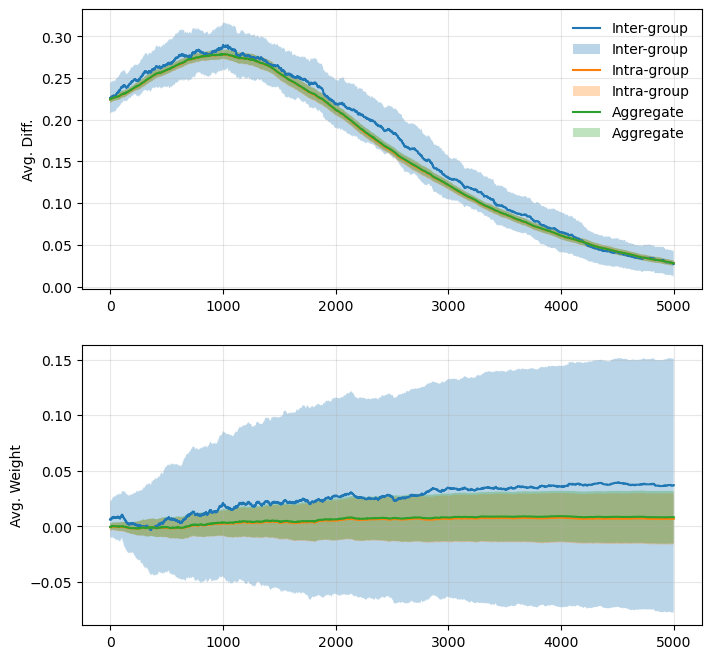

In [68]:
fig, axs = plt.subplots(2,1,figsize=(8,8))

for i, d, ylabel in zip([0,1], ['avg_diff', 'avg_w'], ['Avg. Diff.', 'Avg. Weight']):
    for l in ['inter-group', 'intra-group', 'aggregate']:
        avg = np.mean([v[d][l] for v in log.values()], axis=0)
        std = np.std([v[d][l] for v in log.values()], axis=0)
        axs[i].plot(avg, 
                    label=l.capitalize())
        
        axs[i].fill_between(range(len(avg)),
                            avg+(std/2), avg-(std/2),
                            label=l.capitalize(),
                            alpha=.3)
    
    axs[i].set_ylabel(ylabel)
    axs[i].grid(alpha=.3)
    
axs[0].legend(frameon=False)

fig.show()